In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

### Dataloading

---

In [14]:
from helpers.dataset import InpaintingDataset
from helpers import data_utils
from omegaconf import OmegaConf

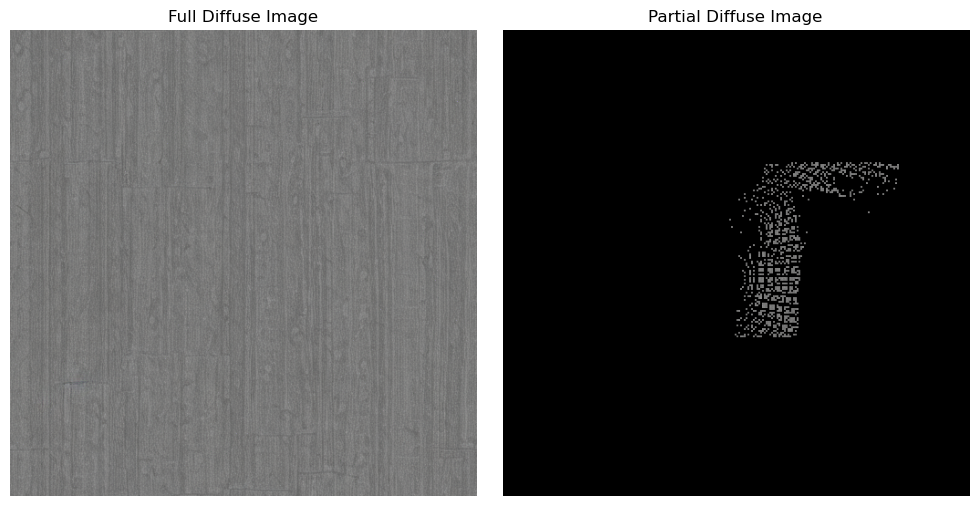

In [15]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

diffuse_img, partial_img = data_utils.channels_last(diffuse_img), data_utils.channels_last(partial_img)
diffuse_img, partial_img = data_utils.denormalise_image(diffuse_img), data_utils.denormalise_image(partial_img)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(diffuse_img)
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(partial_img)
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

### Vae encoding and decoding

---

In [3]:
import os
import torch
from diffusers import AutoencoderKL

from omegaconf import OmegaConf
from helpers.dataset import InpaintingDataset

from matplotlib import pyplot as plt
from helpers import data_utils

/home/cizinsky/venvs/garment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path_to_config = "/home/cizinsky/garment-texture-completion/configs/train.yaml"
with open(path_to_config, "r") as f:
    cfg = OmegaConf.load(f)

vae_path = os.path.join(cfg.model.vae_path, "refine_vae")
vae_diffuse = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae_checkpoint_diffuse",
    revision="fp32",
    local_files_only=True,
    torch_dtype=torch.float32,
).to("cuda").eval()

dataset = InpaintingDataset(cfg)


sample = dataset[0]
diffuse_img, partial_img = sample["full_diffuse_img"][None], sample["partial_diffuse_img"][None]
diffuse_img.shape, partial_img.shape

((1, 3, 512, 512), (1, 3, 512, 512))

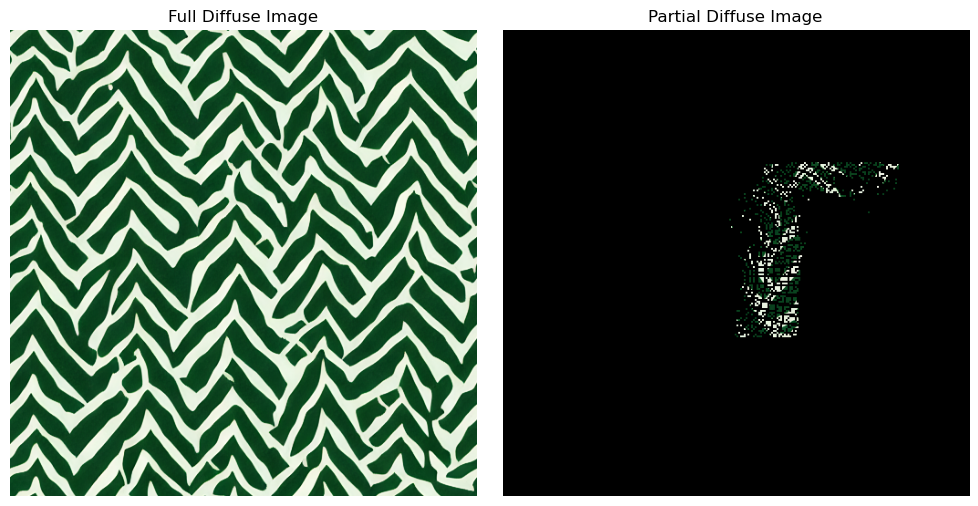

In [5]:
tmp_diffuse_img, tmp_partial_img = data_utils.channels_last(diffuse_img), data_utils.channels_last(partial_img)
tmp_diffuse_img, tmp_partial_img = data_utils.denormalise_image(tmp_diffuse_img), data_utils.denormalise_image(tmp_partial_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(tmp_diffuse_img.squeeze(0))
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(tmp_partial_img.squeeze(0))
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

In [12]:
def encode_decode_image(image, vae):
    # Encode
    with torch.no_grad():
        latents = vae.encode(image.cuda()).latent_dist.sample()
        latents = latents * vae.config.scaling_factor  # scale to match diffusion training

    # Decode
    with torch.no_grad():
        decoded = vae.decode(latents / vae.config.scaling_factor).sample

    return decoded

def post_process_image(image):
    decoded_image = data_utils.channels_last(data_utils.denormalise_image(image.cpu().numpy()))
    return decoded_image

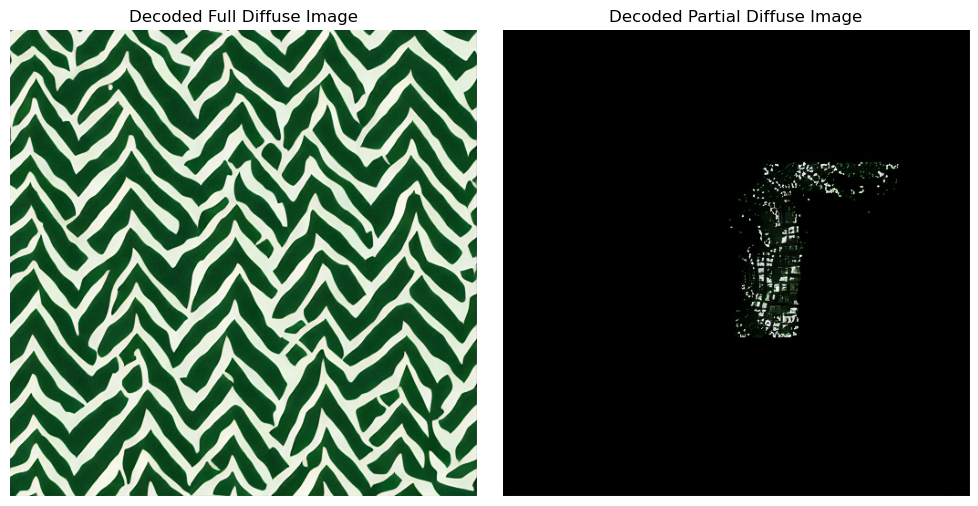

In [13]:
tensor_full, tensor_partial = torch.from_numpy(diffuse_img), torch.from_numpy(partial_img)
decoded_full, decoded_partial = encode_decode_image(tensor_full, vae_diffuse), encode_decode_image(tensor_partial, vae_diffuse)
decoded_full, decoded_partial = post_process_image(decoded_full), post_process_image(decoded_partial)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(decoded_full[0])
ax[0].set_title("Decoded Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(decoded_partial[0])
ax[1].set_title("Decoded Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

---